In [1]:
import os
import glob
import random

import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2


learning_rate = 0.001
batch_size = 10
epochs = 10


device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

In [2]:
train_path = 'C:/Users/kiril/Desktop/Lab5AP/train'
test_path = 'C:/Users/kiril/Desktop/Lab5AP/test'
val_path = 'C:/Users/kiril/Desktop/Lab5AP/val'

path1 = "tiger.csv"
path2 = "leopard.csv"

dfs = []
tmp1 = pd.read_csv(path1, sep=';', header=None)
dfs.append(tmp1)
tmp2 = pd.read_csv(path2, sep=';', header=None)
dfs.append(tmp2)
df = pd.concat(dfs)
print(df)
df.drop(1, axis=1, inplace=True)

df.rename(columns={0: 'absolute_way', 2: 'class_img'}, inplace=True)
df.reset_index(inplace=True)


if not os.path.isdir(train_path):
    os.mkdir(train_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)

if not os.path.isdir(val_path):
    os.mkdir(val_path)



def load_train(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    """loads images from the dataframe along the selected path"""
    image_path = df.absolute_way[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{df.class_img[i]}.{i}.jpg'), image)


def load_val(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    """loads images from the dataframe along the selected path"""
    image_path = df.absolute_way[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)

def load_test(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    """loads images from the dataframe along the selected path"""
    image_path = df.absolute_way[i]
    image = cv2.imread(image_path)
    # if i - 768 > 95:
    #     i = i - 1632
    # else:
    #     i = i - 768
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)



for i in range(768):
    load_train(df, train_path, i)
for i in range(961,1729):
    load_train(df, train_path, i)
for i in range(768,865):
    load_test(df,test_path,i)
for i in range(1729,1826):
    load_test(df,test_path,i)
for i in range(865,960):
    load_val(df,val_path,i)
for i in range(1826,1920):
    load_val(df,val_path,i)



train_list = glob.glob(os.path.join(train_path, '*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg'))
val_list = glob.glob(os.path.join(val_path, '*.jpg'))

# split our data into train and test sets
train_list, val_list = train_test_split(train_list, test_size=0.1)

                                                      0  \
0     C:\Users\kiril\Desktop\Lab5AP\dataset\tiger\00...   
1     C:\Users\kiril\Desktop\Lab5AP\dataset\tiger\00...   
2     C:\Users\kiril\Desktop\Lab5AP\dataset\tiger\00...   
3     C:\Users\kiril\Desktop\Lab5AP\dataset\tiger\00...   
4     C:\Users\kiril\Desktop\Lab5AP\dataset\tiger\00...   
...                                                 ...   
1214  C:\Users\kiril\Desktop\Lab5AP\dataset\leopard\...   
1215  C:\Users\kiril\Desktop\Lab5AP\dataset\leopard\...   
1216  C:\Users\kiril\Desktop\Lab5AP\dataset\leopard\...   
1217  C:\Users\kiril\Desktop\Lab5AP\dataset\leopard\...   
1218  C:\Users\kiril\Desktop\Lab5AP\dataset\leopard\...   

                             1        2  
0       dataset\tiger\0000.jpg    tiger  
1       dataset\tiger\0001.jpg    tiger  
2       dataset\tiger\0002.jpg    tiger  
3       dataset\tiger\0003.jpg    tiger  
4       dataset\tiger\0004.jpg    tiger  
...                        ...      ...

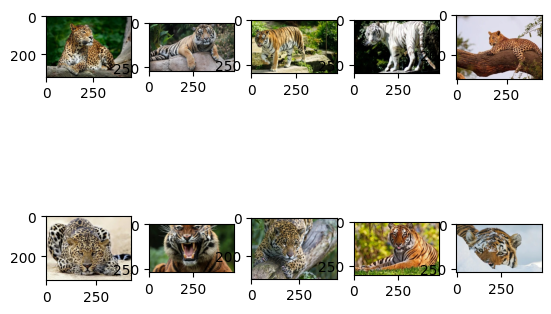

In [3]:
#check out datasets
random_idx = np.random.randint(1,200,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = cv2.imread(train_list[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i+=1

plt.show()

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()


    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

model = ConvNet().to(device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])
#Image Augmentation

In [14]:
#this code is for load our image sets
from PIL import Image

class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split('\\')[-1].split('.')[0]
        
        if label == 'tiger':
            label = 1
        elif label == 'leopard':
            label = 0

        return img_transformed,label


train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

Learning rate: 0.001, Batch size: 10
Epoch : 1, train accuracy : 0.8431651592254639, train loss : 0.39499151706695557
Epoch : 1, val_accuracy : 0.8812499642372131, val_loss : 0.36670079827308655
Epoch : 2, train accuracy : 0.8633090853691101, train loss : 0.36349302530288696
Epoch : 2, val_accuracy : 0.824999988079071, val_loss : 0.38683584332466125
Epoch : 3, train accuracy : 0.8791362047195435, train loss : 0.3335115313529968
Epoch : 3, val_accuracy : 0.8187500238418579, val_loss : 0.41279155015945435
Epoch : 4, train accuracy : 0.858272910118103, train loss : 0.35705626010894775
Epoch : 4, val_accuracy : 0.890625, val_loss : 0.33870741724967957
Epoch : 5, train accuracy : 0.879136323928833, train loss : 0.3334774374961853
Epoch : 5, val_accuracy : 0.8343749642372131, val_loss : 0.3880046308040619
Epoch : 6, train accuracy : 0.8877695202827454, train loss : 0.3111724853515625
Epoch : 6, val_accuracy : 0.8656249642372131, val_loss : 0.3486435115337372
Epoch : 7, train accuracy : 0.886

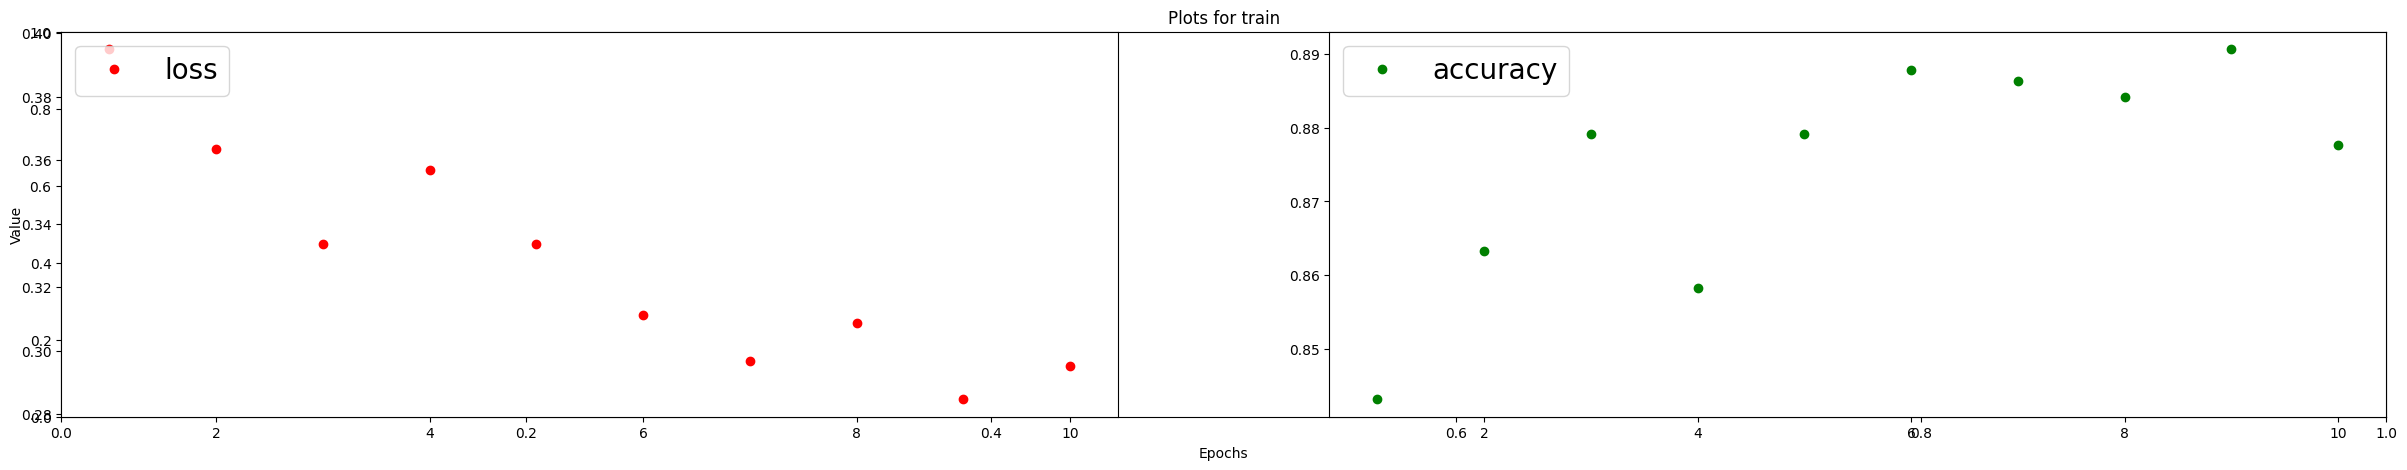

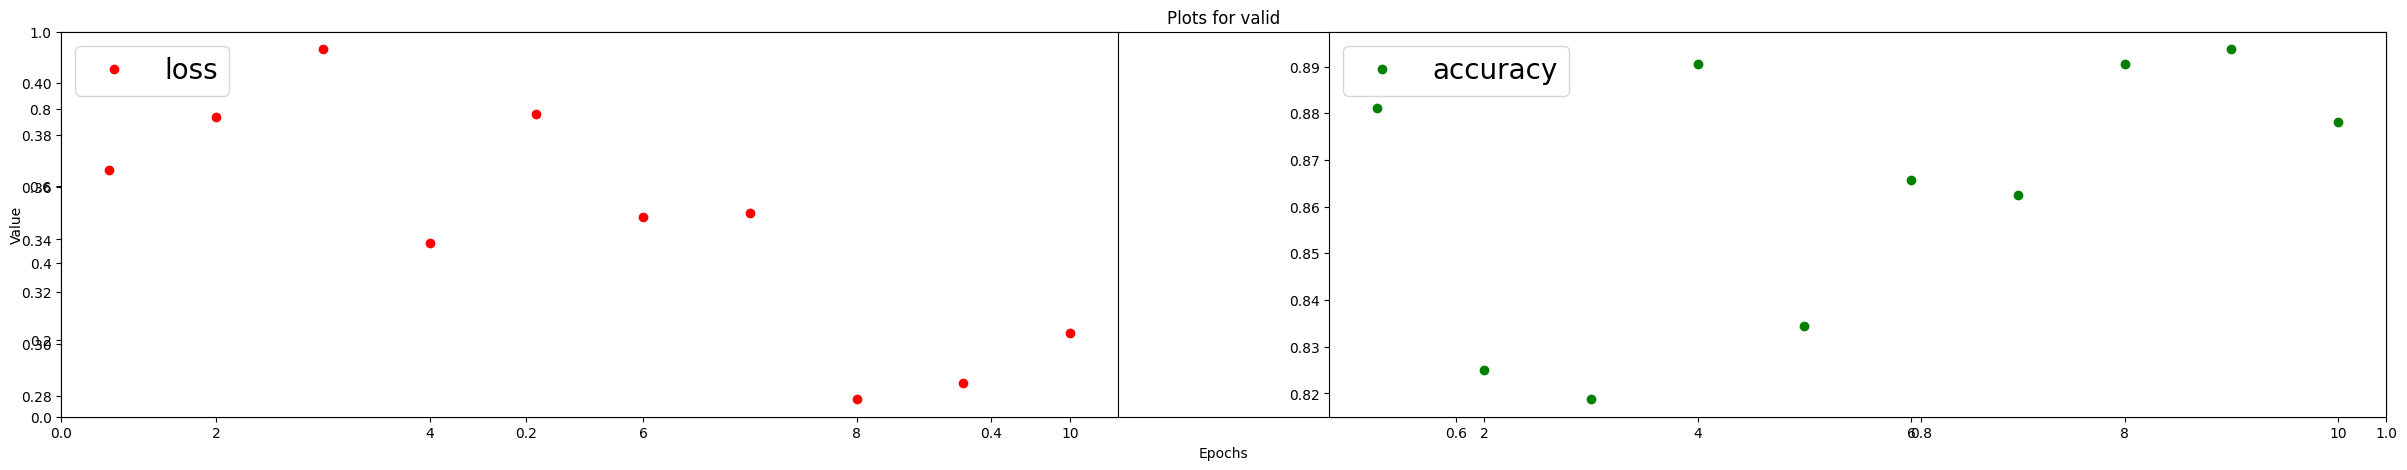

In [15]:
print('Learning rate: 0.001, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

epochs = 10
def train_loop (train_loader, val_loader, epochs):
    val_loss_list = []
    val_accuracy_list = []

    loss_list = []
    accuracy_list = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)

        loss_list.append(epoch_loss.item())
        accuracy_list.append(epoch_accuracy.item())

        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))


        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0

            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output,label)

                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)


            val_loss_list.append(epoch_val_loss.item())
            val_accuracy_list.append(epoch_val_accuracy.item())

            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))


    num_epochs = [i+1 for i in range(epochs)]

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for train')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1,2,1)
    plt.plot(num_epochs, loss_list, 'ro', label = 'loss')
    plt.legend(loc=2, prop={'size': 20})
    fig.add_subplot(1,2,2)
    plt.plot(num_epochs, accuracy_list, 'go', label = 'accuracy')
    plt.legend(loc=2, prop={'size': 20})

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for valid')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1,2,1)
    plt.plot(num_epochs, val_loss_list, 'ro', label = 'loss')
    plt.legend(loc=2, prop={'size': 20})
    fig.add_subplot(1,2,2)
    plt.plot(num_epochs, val_accuracy_list, 'go', label = 'accuracy')
    plt.legend(loc=2, prop={'size': 20})

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 10
Epoch : 1, train accuracy : 0.904315710067749, train loss : 0.26024460792541504
Epoch : 1, val_accuracy : 0.949999988079071, val_loss : 0.21766312420368195
Epoch : 2, train accuracy : 0.9151071906089783, train loss : 0.23340289294719696
Epoch : 2, val_accuracy : 0.8593749403953552, val_loss : 0.3383404016494751
Epoch : 3, train accuracy : 0.9093517065048218, train loss : 0.25018736720085144
Epoch : 3, val_accuracy : 0.9218749403953552, val_loss : 0.25058838725090027
Epoch : 4, train accuracy : 0.9151073694229126, train loss : 0.23570480942726135
Epoch : 4, val_accuracy : 0.8968749642372131, val_loss : 0.26068463921546936
Epoch : 5, train accuracy : 0.907193660736084, train loss : 0.24165087938308716
Epoch : 5, val_accuracy : 0.9125000238418579, val_loss : 0.2527002990245819
Epoch : 6, train accuracy : 0.9021576046943665, train loss : 0.2516248822212219
Epoch : 6, val_accuracy : 0.956250011920929, val_loss : 0.20709218084812164
Epoch : 7, train accu

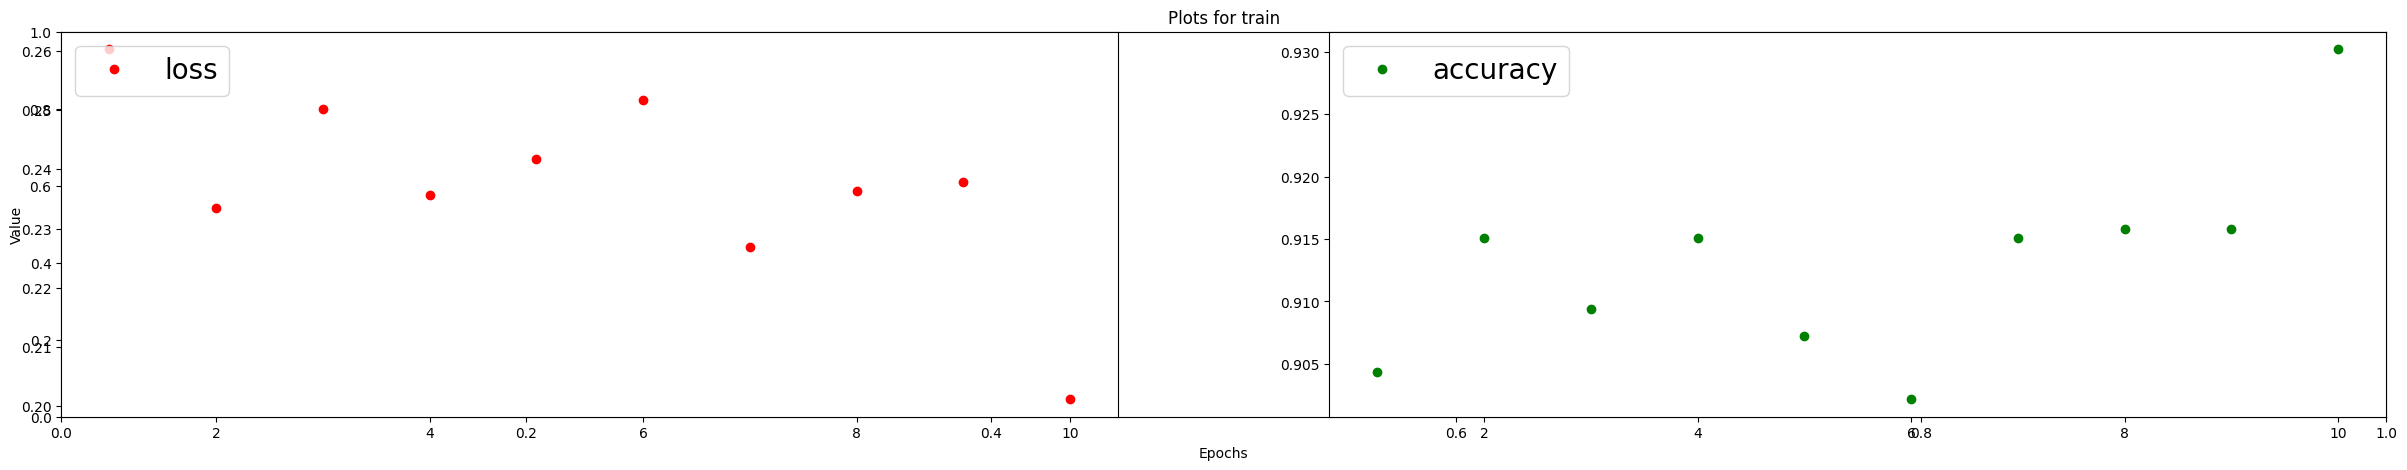

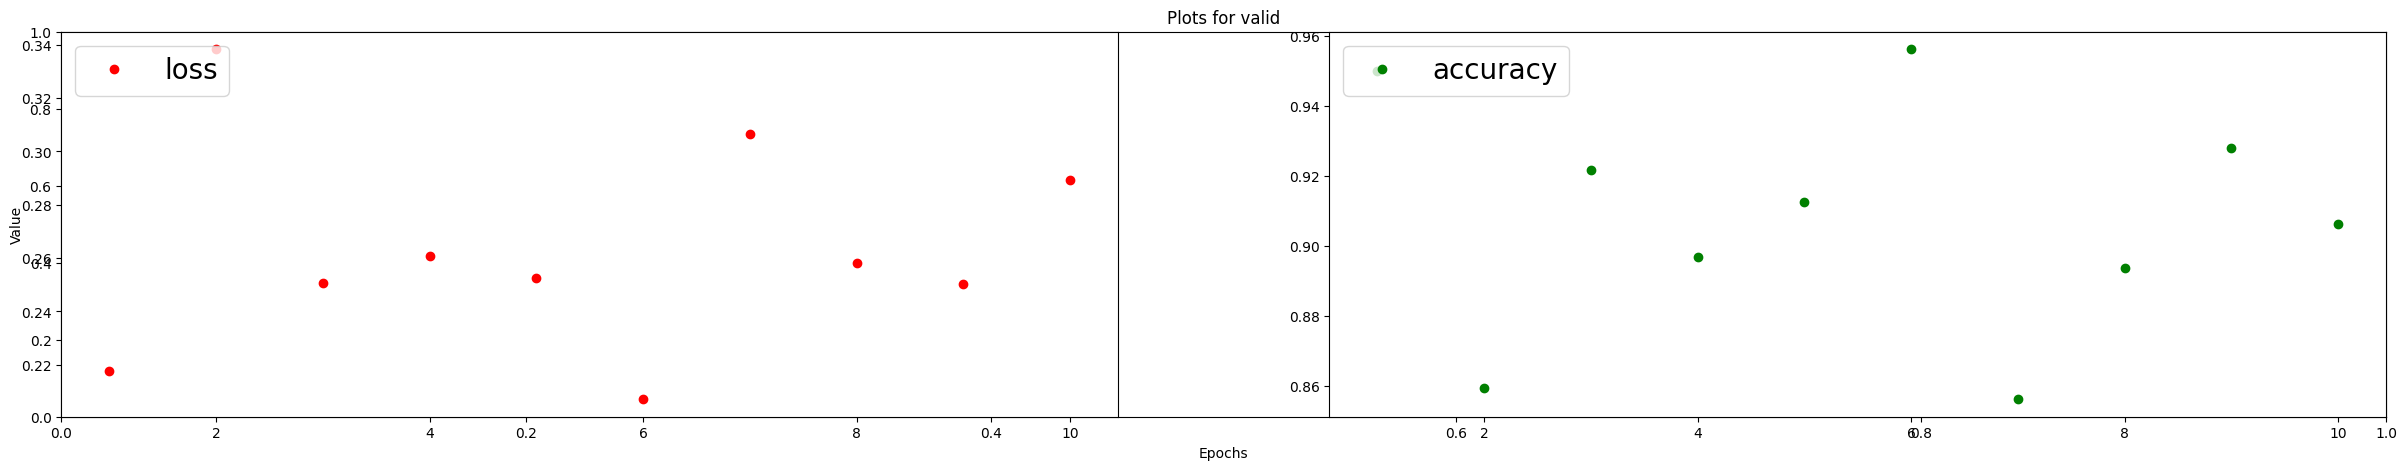

In [16]:
print('Learning rate: 0.0005, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 10
Epoch : 1, train accuracy : 0.9064739942550659, train loss : 0.2531326115131378
Epoch : 1, val_accuracy : 0.9499999284744263, val_loss : 0.21170377731323242
Epoch : 2, train accuracy : 0.9115102291107178, train loss : 0.22332513332366943
Epoch : 2, val_accuracy : 0.9312499761581421, val_loss : 0.18920071423053741
Epoch : 3, train accuracy : 0.9215818643569946, train loss : 0.2033384144306183
Epoch : 3, val_accuracy : 0.8718749284744263, val_loss : 0.2959456443786621
Epoch : 4, train accuracy : 0.9151070713996887, train loss : 0.2211693376302719
Epoch : 4, val_accuracy : 0.9156249761581421, val_loss : 0.19494159519672394
Epoch : 5, train accuracy : 0.9158267974853516, train loss : 0.21866965293884277
Epoch : 5, val_accuracy : 0.925000011920929, val_loss : 0.23145604133605957
Epoch : 6, train accuracy : 0.9338120818138123, train loss : 0.20251524448394775
Epoch : 6, val_accuracy : 0.8812499642372131, val_loss : 0.25786352157592773
Epoch : 7, train ac

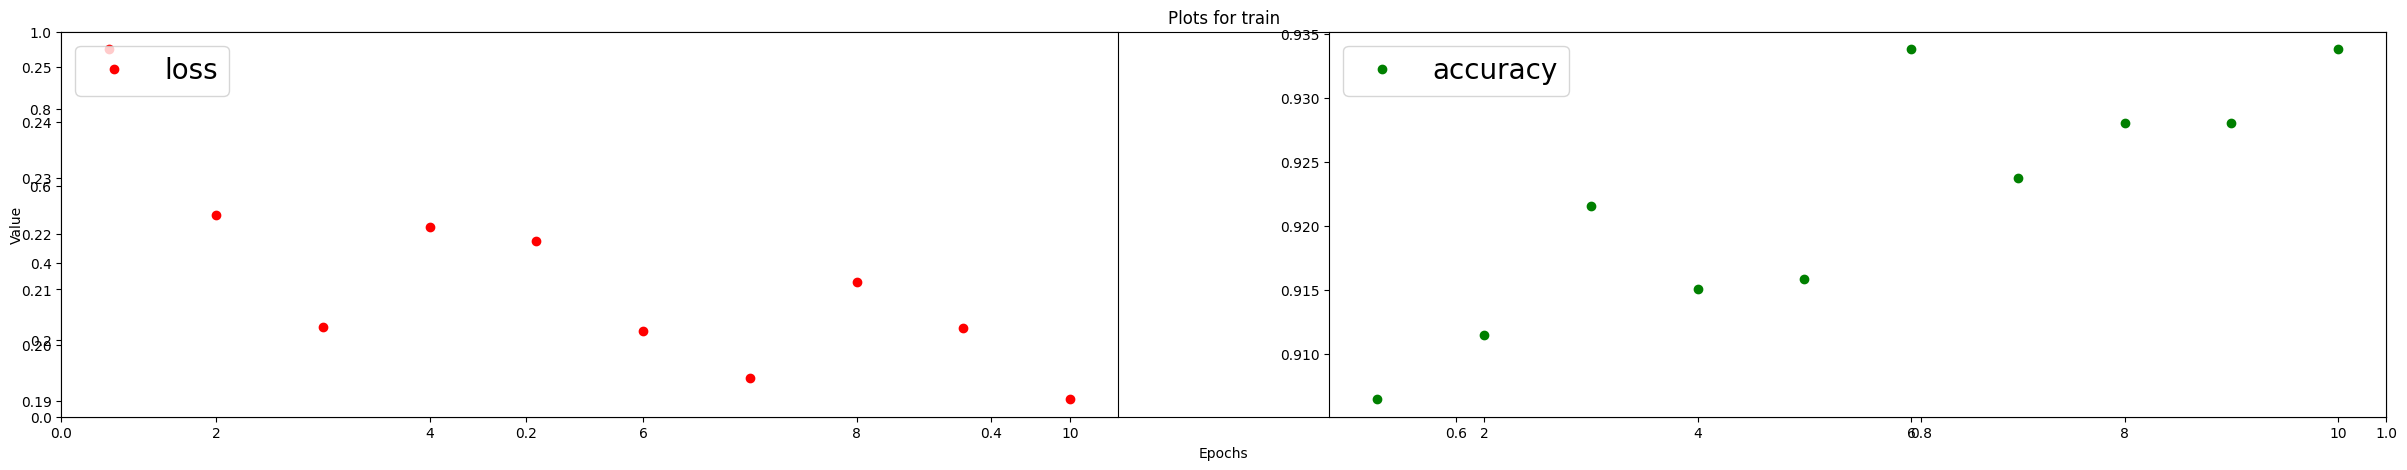

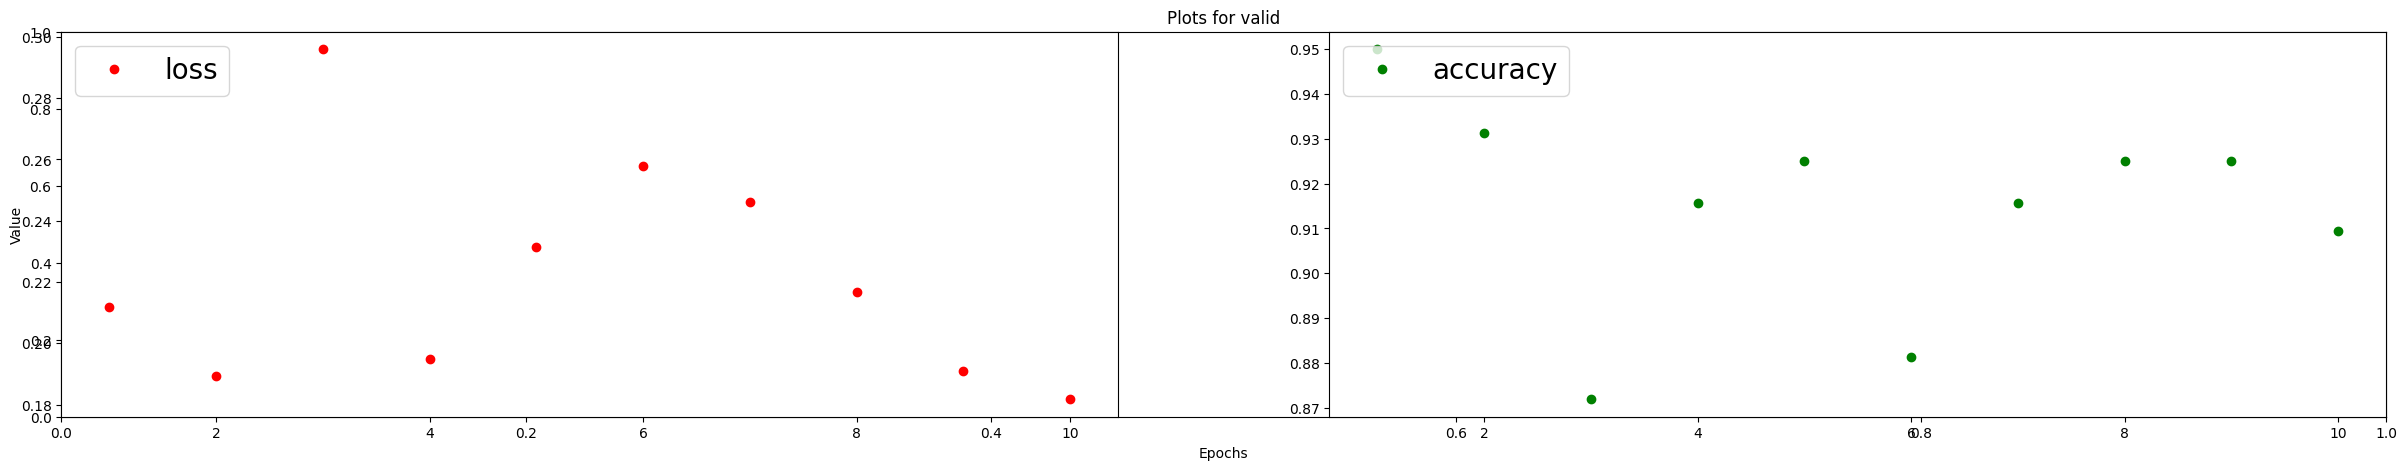

In [17]:
print('Learning rate: 0.0007, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.001, Batch size: 20
Epoch : 1, train accuracy : 0.9464288949966431, train loss : 0.16802099347114563
Epoch : 1, val_accuracy : 0.9624999761581421, val_loss : 0.12569499015808105
Epoch : 2, train accuracy : 0.9300004839897156, train loss : 0.19067510962486267
Epoch : 2, val_accuracy : 0.9437499642372131, val_loss : 0.1922885924577713
Epoch : 3, train accuracy : 0.9321433305740356, train loss : 0.18447263538837433
Epoch : 3, val_accuracy : 0.966071367263794, val_loss : 0.13803313672542572
Epoch : 4, train accuracy : 0.9500005841255188, train loss : 0.14269936084747314
Epoch : 4, val_accuracy : 0.9437499642372131, val_loss : 0.20449000597000122
Epoch : 5, train accuracy : 0.9557148814201355, train loss : 0.13832169771194458
Epoch : 5, val_accuracy : 0.956250011920929, val_loss : 0.17339397966861725
Epoch : 6, train accuracy : 0.9435719847679138, train loss : 0.16013182699680328
Epoch : 6, val_accuracy : 0.9660714268684387, val_loss : 0.10394872725009918
Epoch : 7, train a

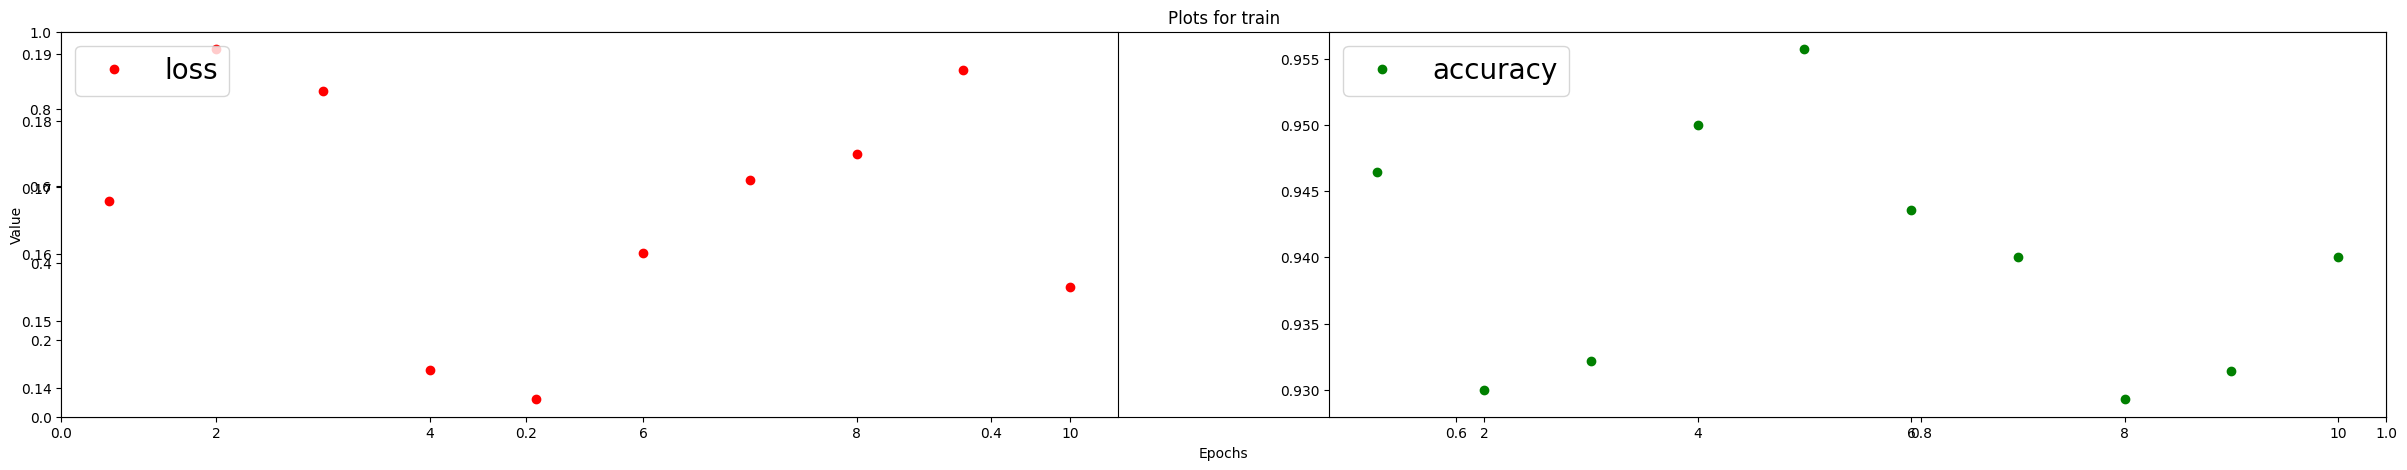

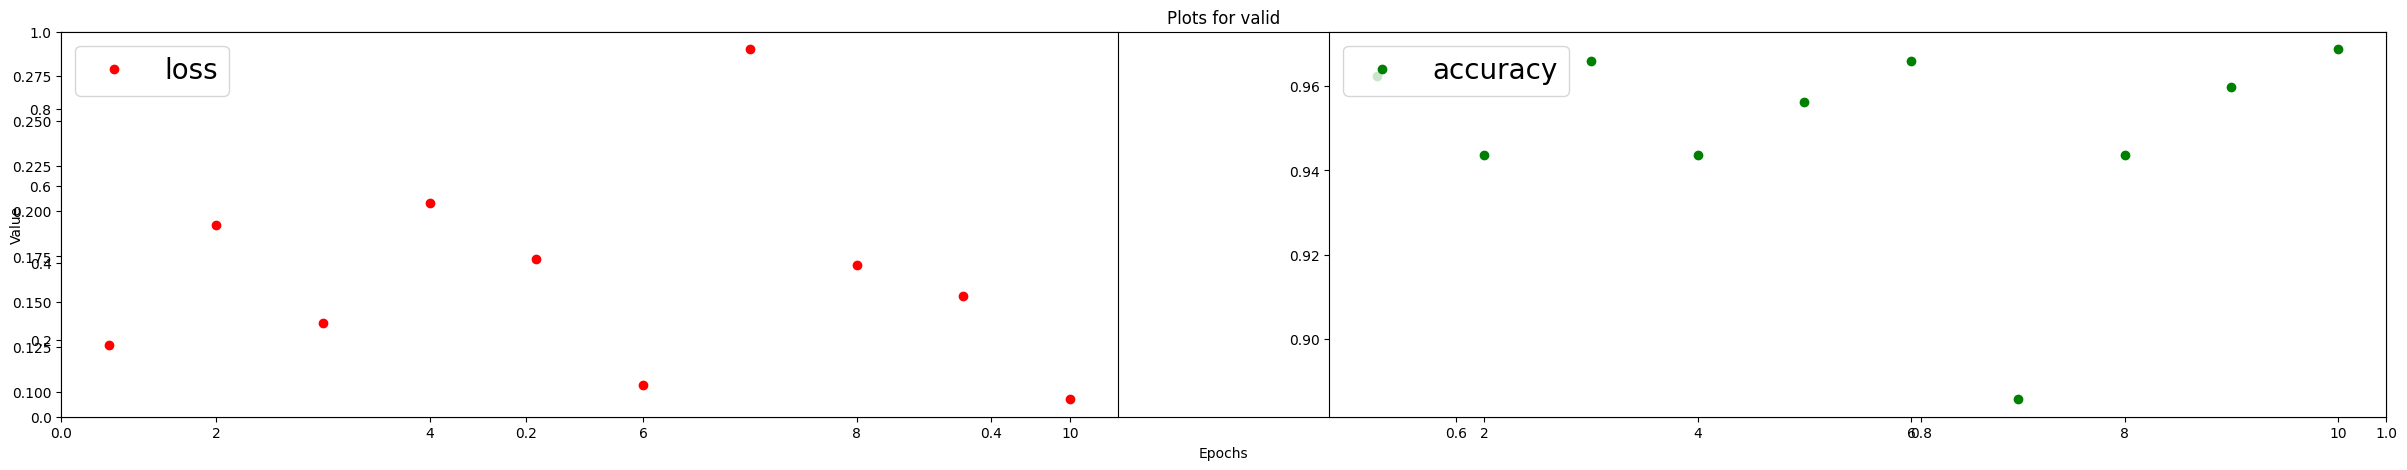

In [18]:
print('Learning rate: 0.001, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 20
Epoch : 1, train accuracy : 0.9478576183319092, train loss : 0.1467493325471878
Epoch : 1, val_accuracy : 0.9562499523162842, val_loss : 0.11774399131536484
Epoch : 2, train accuracy : 0.9564291834831238, train loss : 0.1303827315568924
Epoch : 2, val_accuracy : 0.949999988079071, val_loss : 0.15993505716323853
Epoch : 3, train accuracy : 0.9471433162689209, train loss : 0.14491267502307892
Epoch : 3, val_accuracy : 0.956250011920929, val_loss : 0.1329689770936966
Epoch : 4, train accuracy : 0.9407148957252502, train loss : 0.159250870347023
Epoch : 4, val_accuracy : 0.9562499523162842, val_loss : 0.1526542752981186
Epoch : 5, train accuracy : 0.9550005197525024, train loss : 0.13301613926887512
Epoch : 5, val_accuracy : 0.956250011920929, val_loss : 0.1127750426530838
Epoch : 6, train accuracy : 0.9664292931556702, train loss : 0.1117510125041008
Epoch : 6, val_accuracy : 0.934821367263794, val_loss : 0.1490134745836258
Epoch : 7, train accuracy :

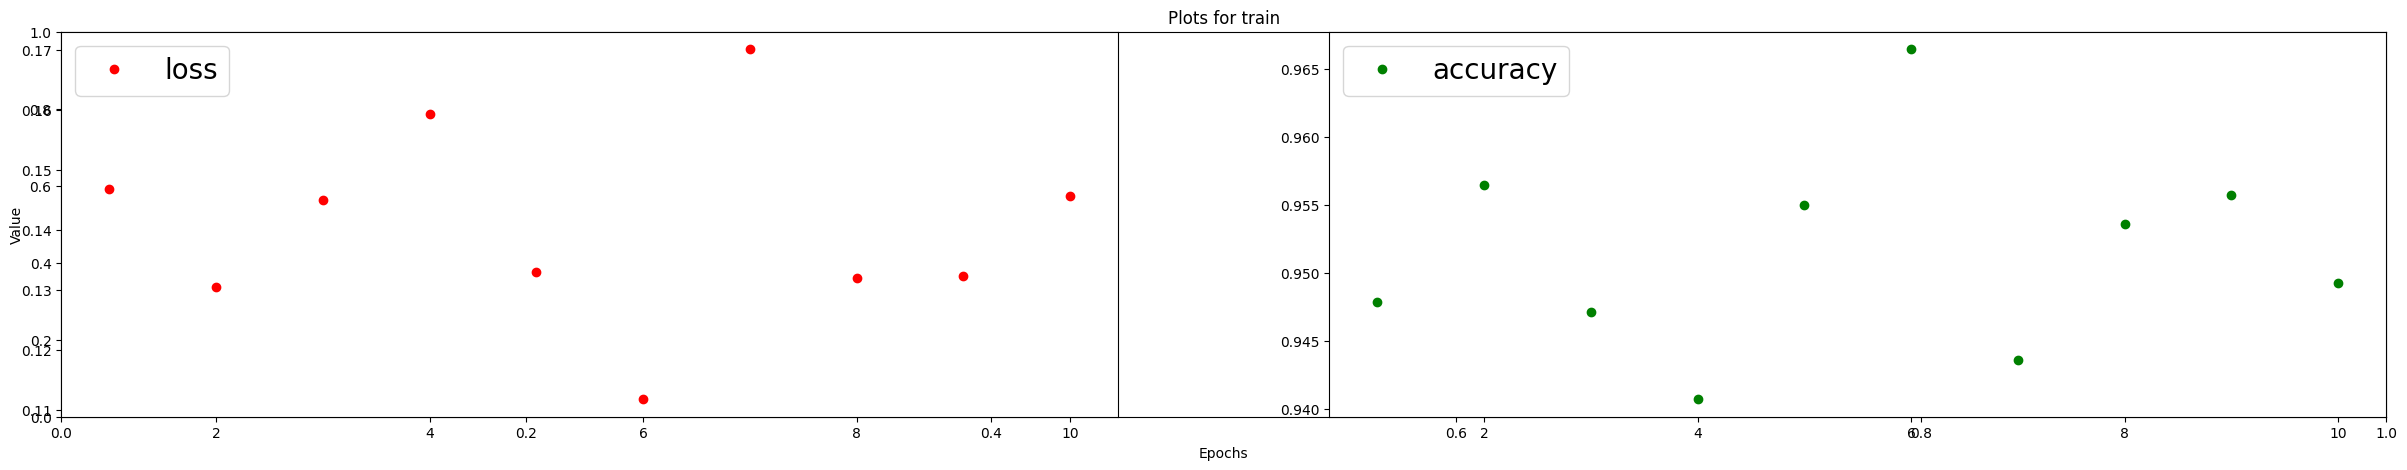

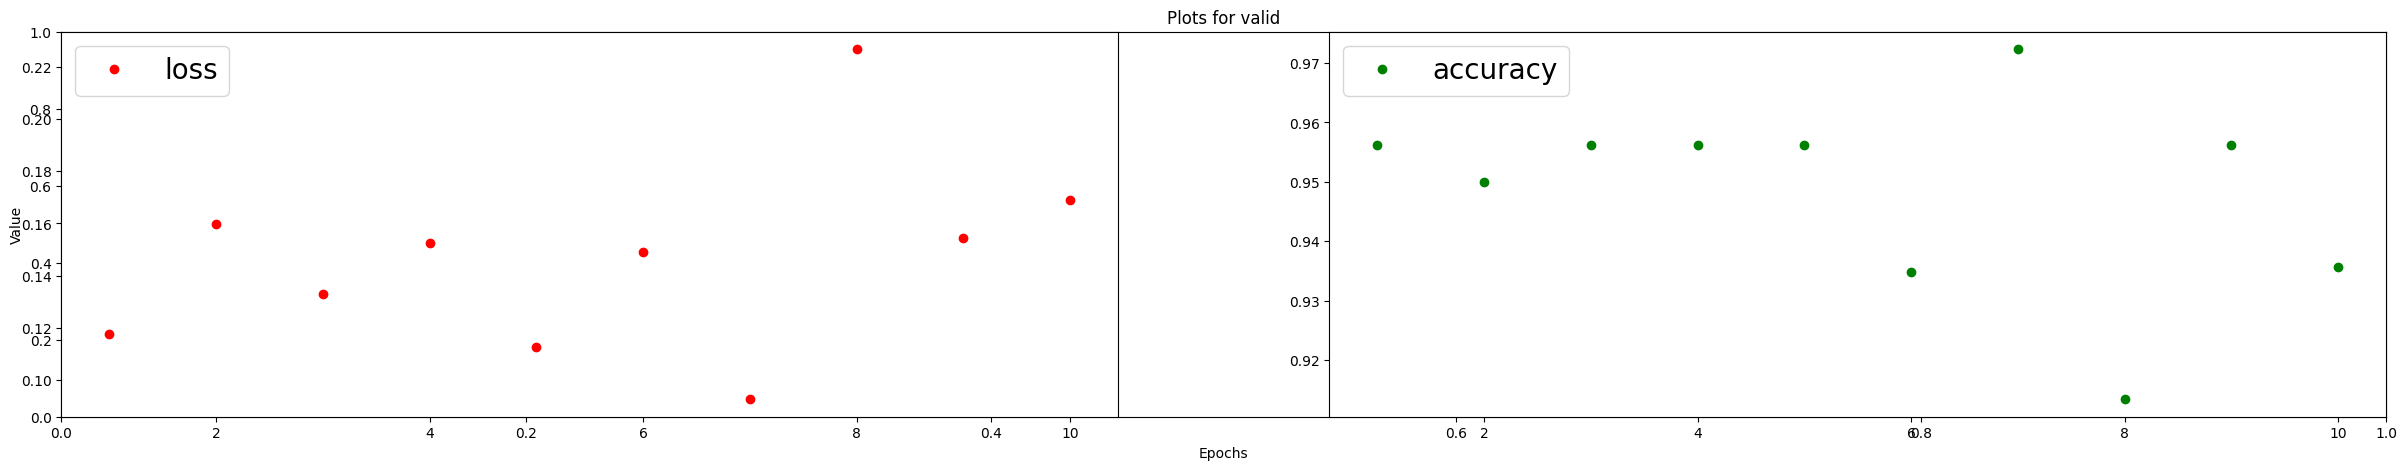

In [19]:
print('Learning rate: 0.0005, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 20
Epoch : 1, train accuracy : 0.9435719847679138, train loss : 0.14195241034030914
Epoch : 1, val_accuracy : 0.96875, val_loss : 0.10994811356067657
Epoch : 2, train accuracy : 0.9385719895362854, train loss : 0.17335131764411926
Epoch : 2, val_accuracy : 0.9250000715255737, val_loss : 0.19141368567943573
Epoch : 3, train accuracy : 0.9500005841255188, train loss : 0.14119742810726166
Epoch : 3, val_accuracy : 0.9535714387893677, val_loss : 0.15247833728790283
Epoch : 4, train accuracy : 0.9542862772941589, train loss : 0.14008386433124542
Epoch : 4, val_accuracy : 0.9285714030265808, val_loss : 0.17456796765327454
Epoch : 5, train accuracy : 0.948572039604187, train loss : 0.13175274431705475
Epoch : 5, val_accuracy : 0.966071367263794, val_loss : 0.07841357588768005
Epoch : 6, train accuracy : 0.955000638961792, train loss : 0.12180224806070328
Epoch : 6, val_accuracy : 0.9437499642372131, val_loss : 0.13241496682167053
Epoch : 7, train accuracy : 

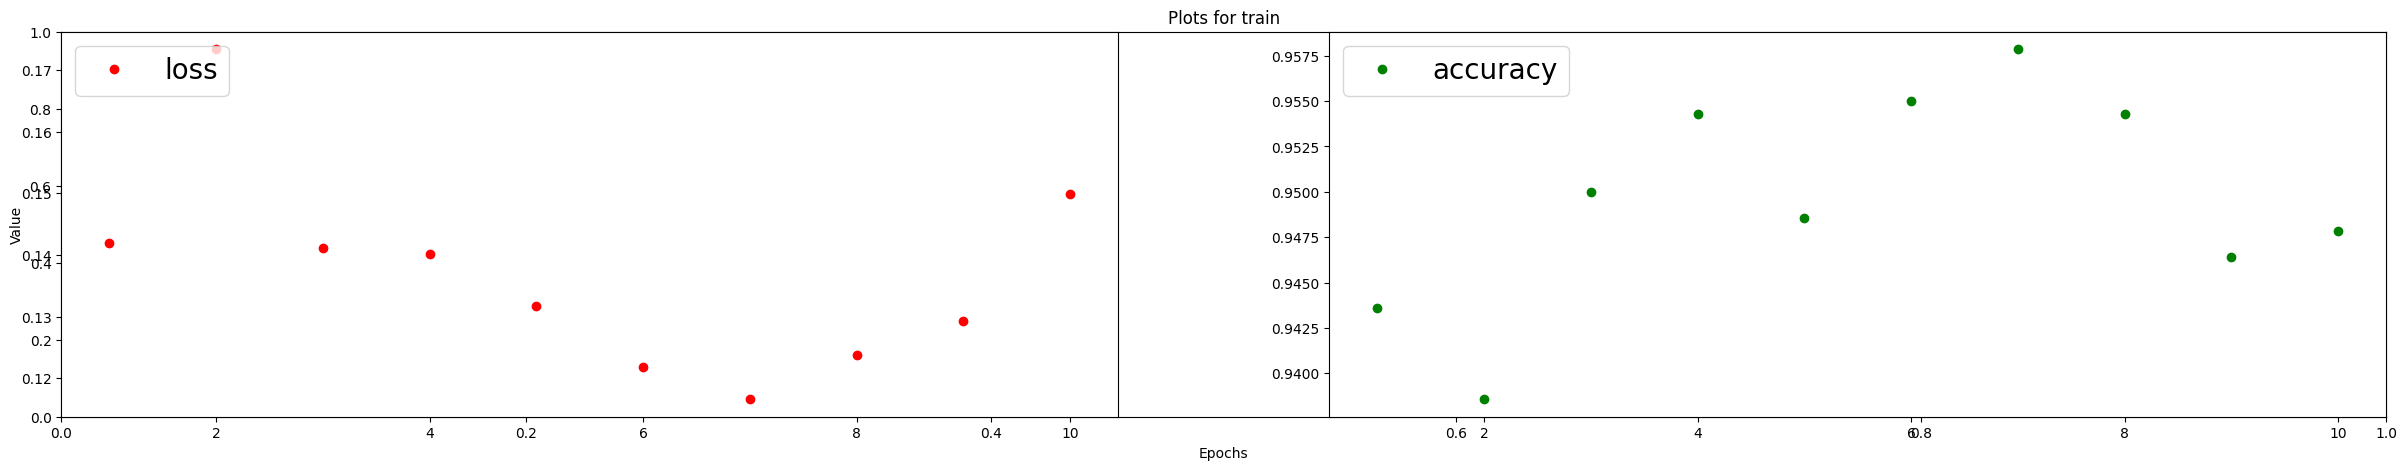

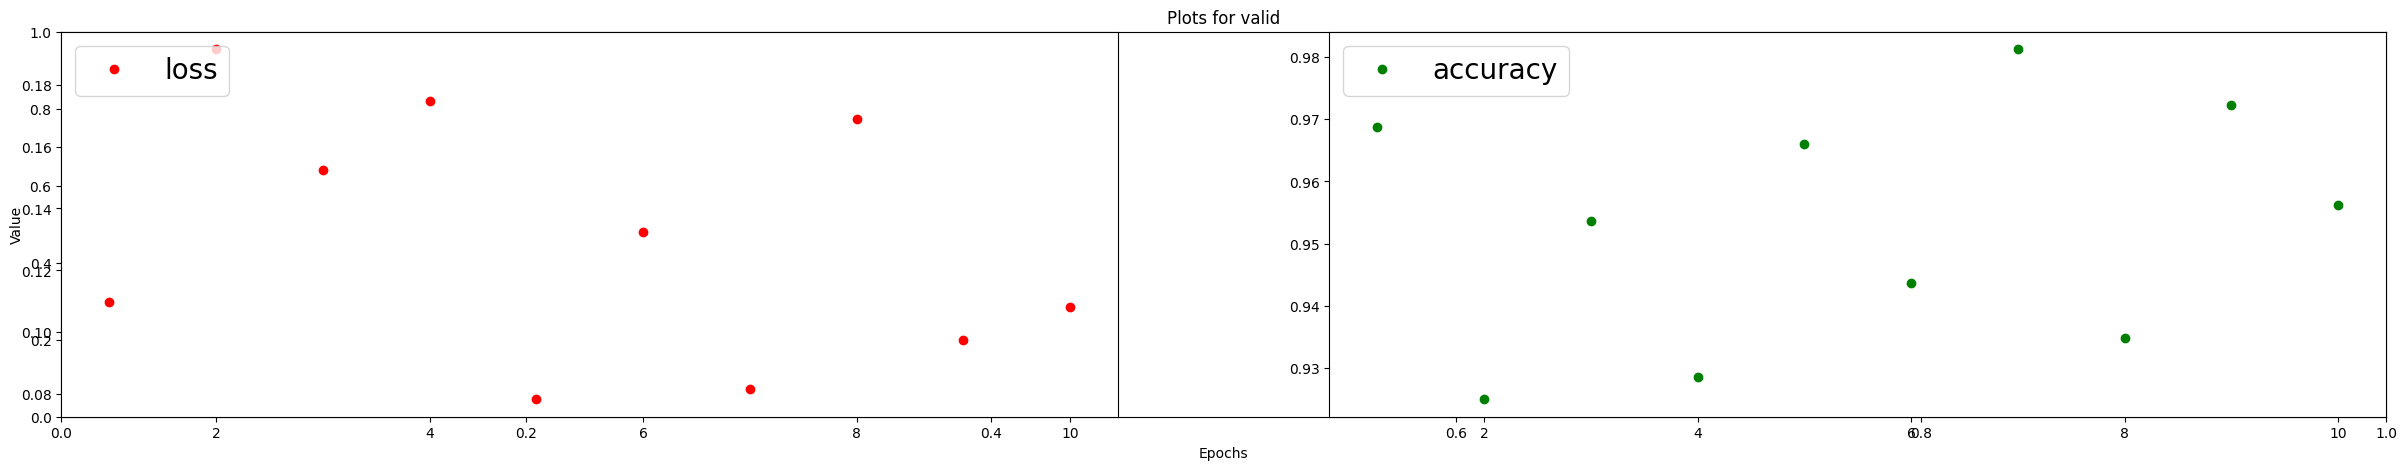

In [20]:
print('Learning rate: 0.0007, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.001, Batch size: 50
Epoch : 1, train accuracy : 0.9609376788139343, train loss : 0.11402202397584915
Epoch : 1, val_accuracy : 0.9074999690055847, val_loss : 0.14030542969703674
Epoch : 2, train accuracy : 0.9634822010993958, train loss : 0.10417429357767105
Epoch : 2, val_accuracy : 0.9075000286102295, val_loss : 0.2966635227203369
Epoch : 3, train accuracy : 0.9552233219146729, train loss : 0.1336788833141327
Epoch : 3, val_accuracy : 0.9599999785423279, val_loss : 0.12053437530994415
Epoch : 4, train accuracy : 0.9563393592834473, train loss : 0.11250898987054825
Epoch : 4, val_accuracy : 0.9600000381469727, val_loss : 0.12984620034694672
Epoch : 5, train accuracy : 0.969910740852356, train loss : 0.09364470839500427
Epoch : 5, val_accuracy : 0.9225000143051147, val_loss : 0.14464056491851807
Epoch : 6, train accuracy : 0.9563391804695129, train loss : 0.11778299510478973
Epoch : 6, val_accuracy : 0.9750000238418579, val_loss : 0.07874094694852829
Epoch : 7, train a

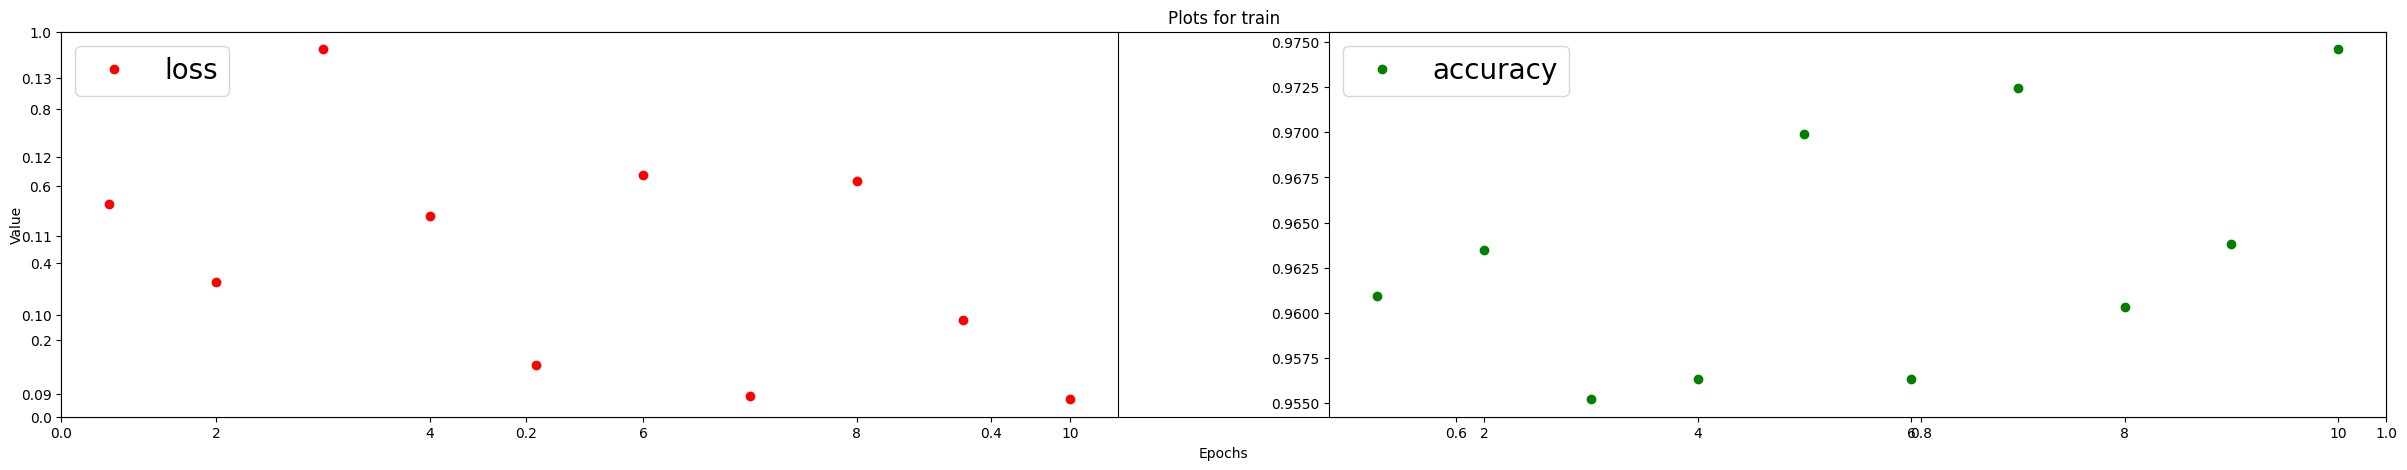

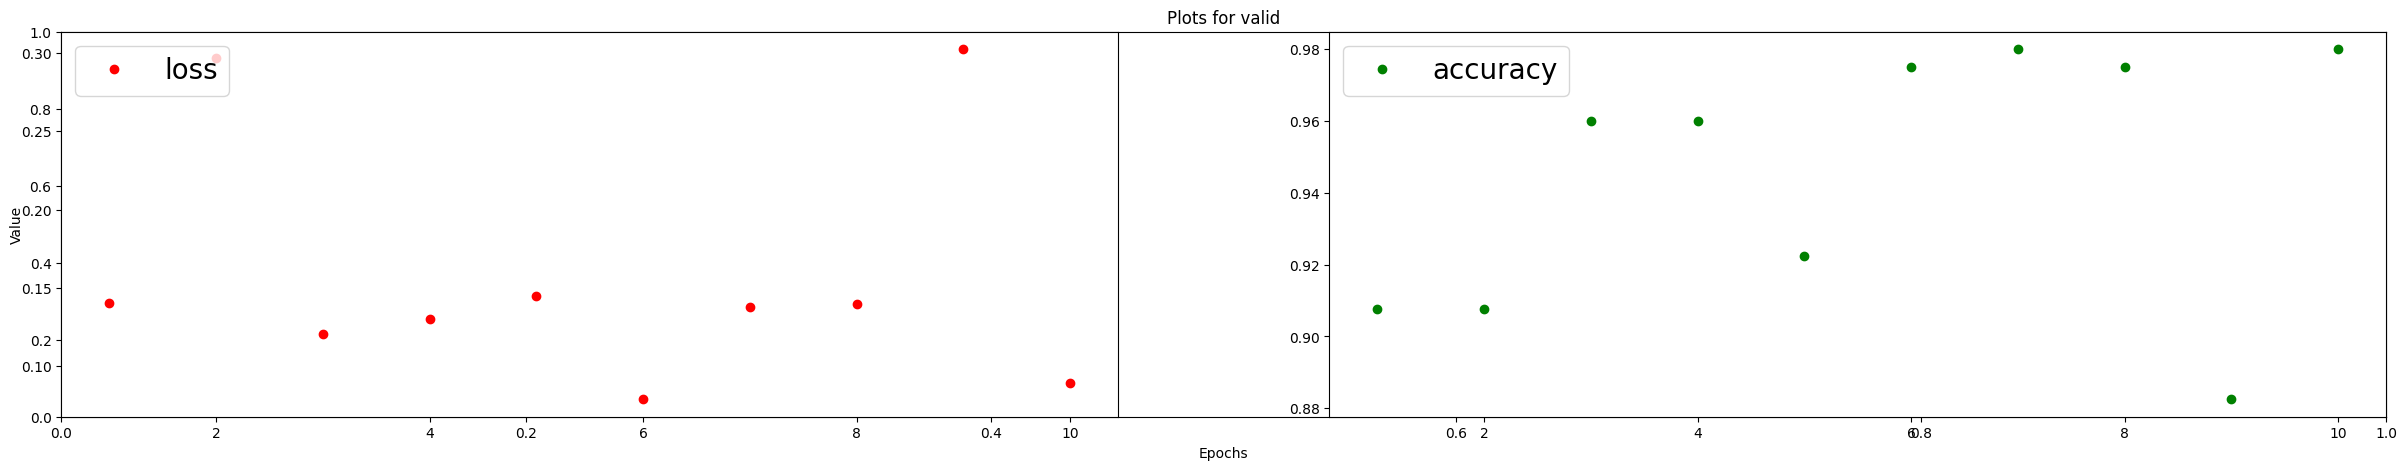

In [21]:
print('Learning rate: 0.001, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 50
Epoch : 1, train accuracy : 0.9613393545150757, train loss : 0.10068274289369583
Epoch : 1, val_accuracy : 0.9850000143051147, val_loss : 0.0691857561469078
Epoch : 2, train accuracy : 0.9613392949104309, train loss : 0.10107322037220001
Epoch : 2, val_accuracy : 0.9650000333786011, val_loss : 0.10148946940898895
Epoch : 3, train accuracy : 0.9667410850524902, train loss : 0.09474389255046844
Epoch : 3, val_accuracy : 0.9175000190734863, val_loss : 0.1817971169948578
Epoch : 4, train accuracy : 0.975714385509491, train loss : 0.08305801451206207
Epoch : 4, val_accuracy : 0.9125000238418579, val_loss : 0.2868661880493164
Epoch : 5, train accuracy : 0.9721429347991943, train loss : 0.07944529503583908
Epoch : 5, val_accuracy : 0.9750000238418579, val_loss : 0.11019959300756454
Epoch : 6, train accuracy : 0.9699108600616455, train loss : 0.08438967913389206
Epoch : 6, val_accuracy : 0.9800000190734863, val_loss : 0.15442481637001038
Epoch : 7, train a

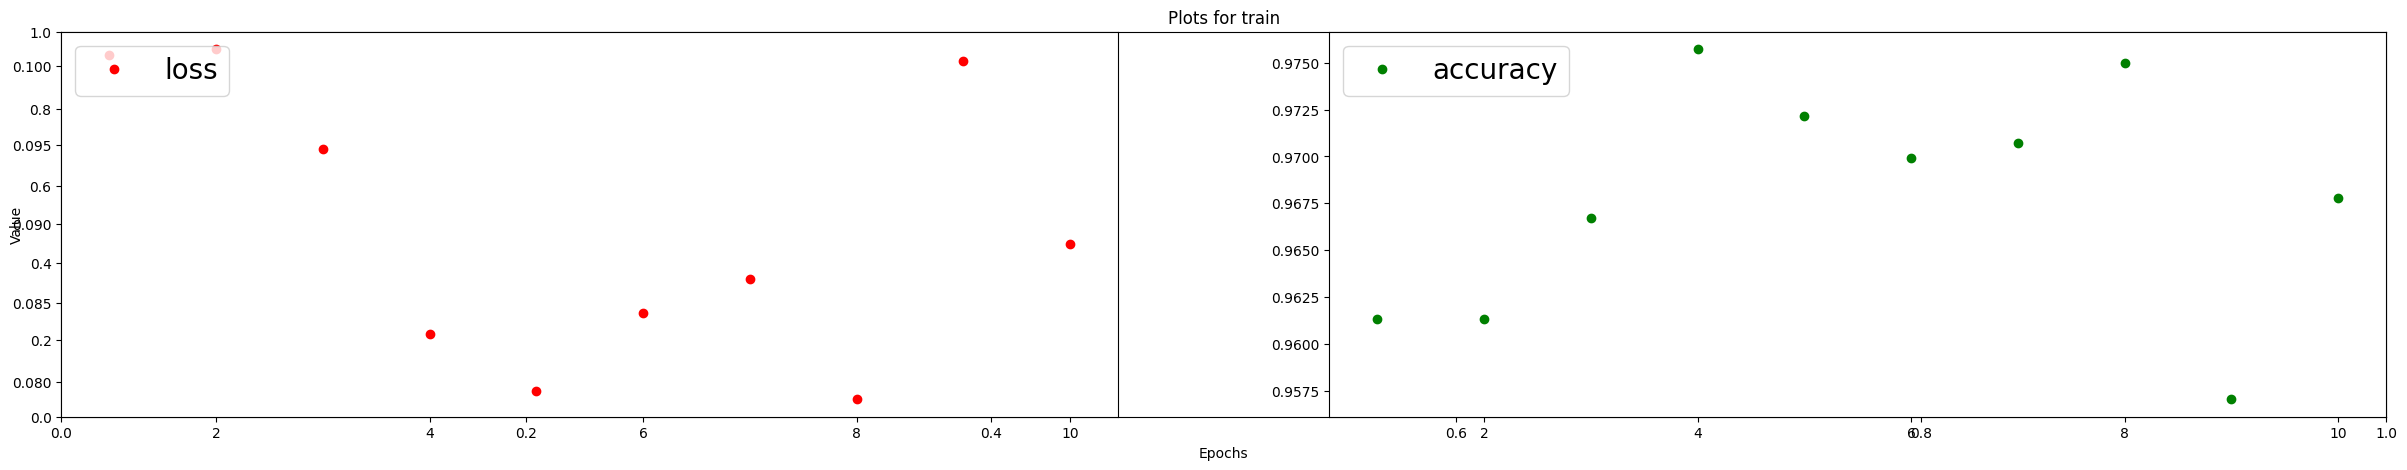

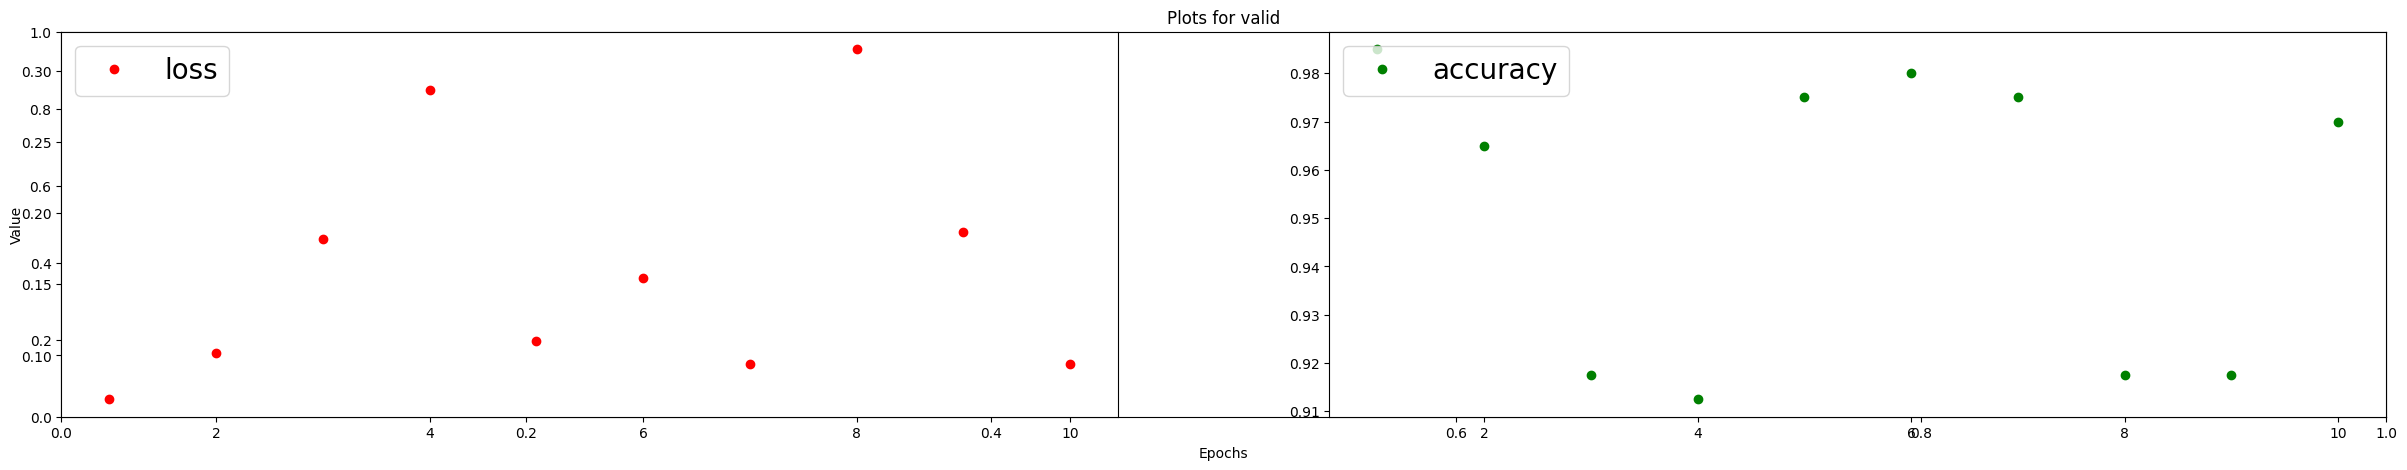

In [22]:
print('Learning rate: 0.0005, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 50
Epoch : 1, train accuracy : 0.973884105682373, train loss : 0.07823647558689117
Epoch : 1, val_accuracy : 0.9175000190734863, val_loss : 0.2396751493215561
Epoch : 2, train accuracy : 0.9759376049041748, train loss : 0.07468922436237335
Epoch : 2, val_accuracy : 0.9550000429153442, val_loss : 0.16504286229610443
Epoch : 3, train accuracy : 0.9687947630882263, train loss : 0.09041621536016464
Epoch : 3, val_accuracy : 0.9800000190734863, val_loss : 0.07702742516994476
Epoch : 4, train accuracy : 0.9703125357627869, train loss : 0.09622807055711746
Epoch : 4, val_accuracy : 0.9800000190734863, val_loss : 0.09393961727619171
Epoch : 5, train accuracy : 0.9506250023841858, train loss : 0.11285459250211716
Epoch : 5, val_accuracy : 0.9850000143051147, val_loss : 0.04955019801855087
Epoch : 6, train accuracy : 0.9663393497467041, train loss : 0.09177590161561966
Epoch : 6, val_accuracy : 0.9600000381469727, val_loss : 0.11003048717975616
Epoch : 7, train

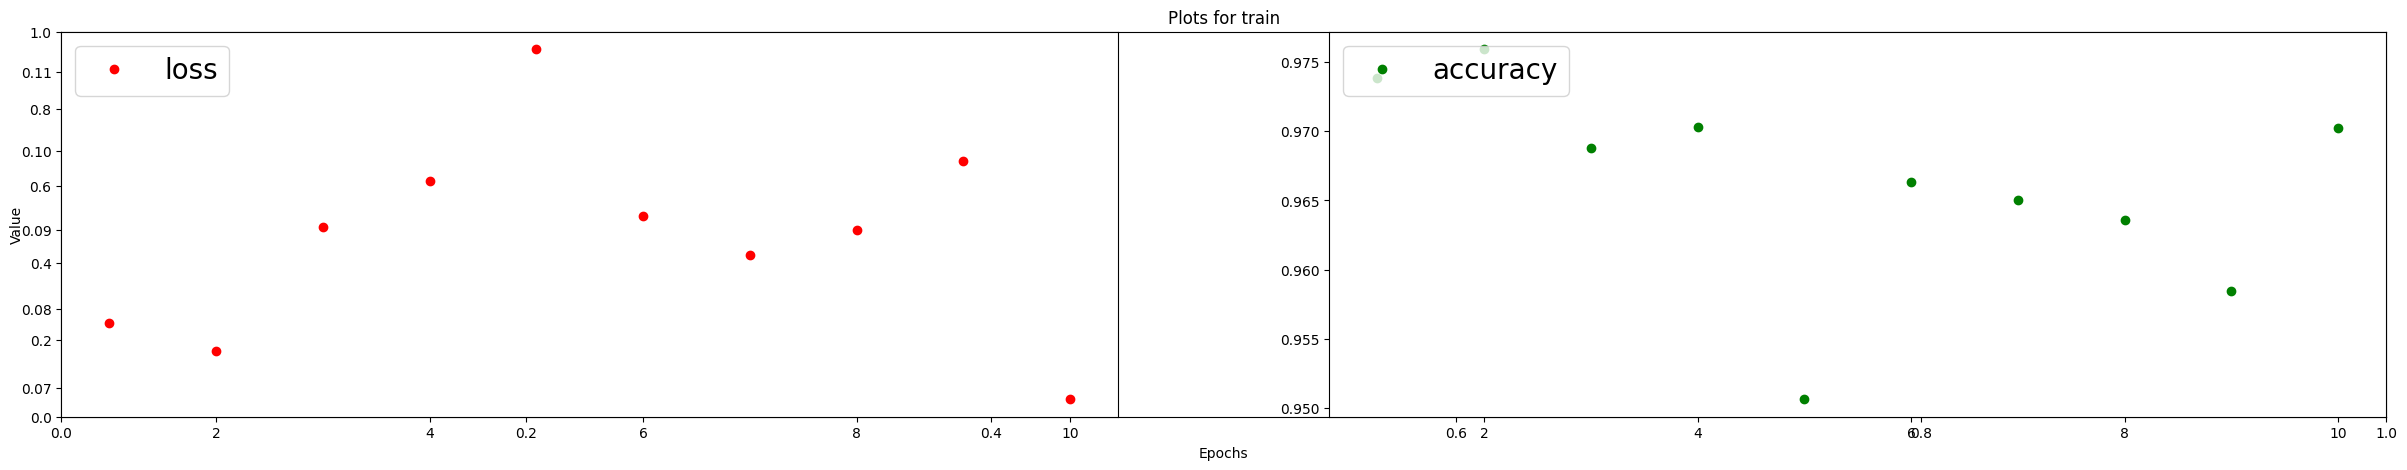

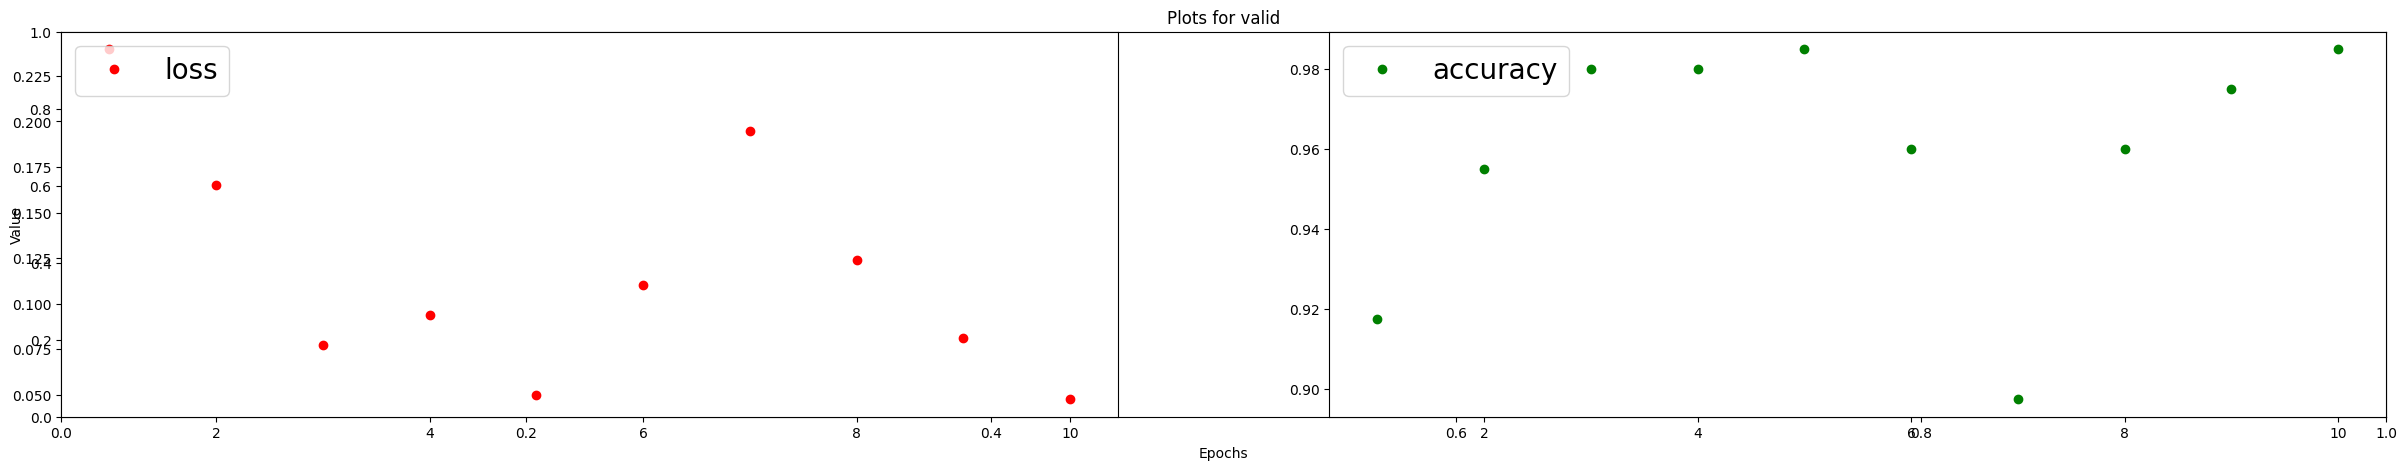

In [23]:
print('Learning rate: 0.0007, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

In [24]:
tiger_probs = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        preds = model(images)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        tiger_probs += list(zip(labels, preds_list))

idx = list(map(lambda x: x[0],tiger_probs))
prob = list(map(lambda x: x[1],tiger_probs))

submission = pd.DataFrame({'id':idx,'label':prob})

submission

id     label
0     851  0.999999
1     794  0.955970
2    1759  0.048255
3    1821  0.003891
4    1777  0.007976
..    ...       ...
189  1734  0.015722
190  1817  0.468546
191  1760  0.028615
192  1736  0.011618
193  1733  0.643314

[194 rows x 2 columns]

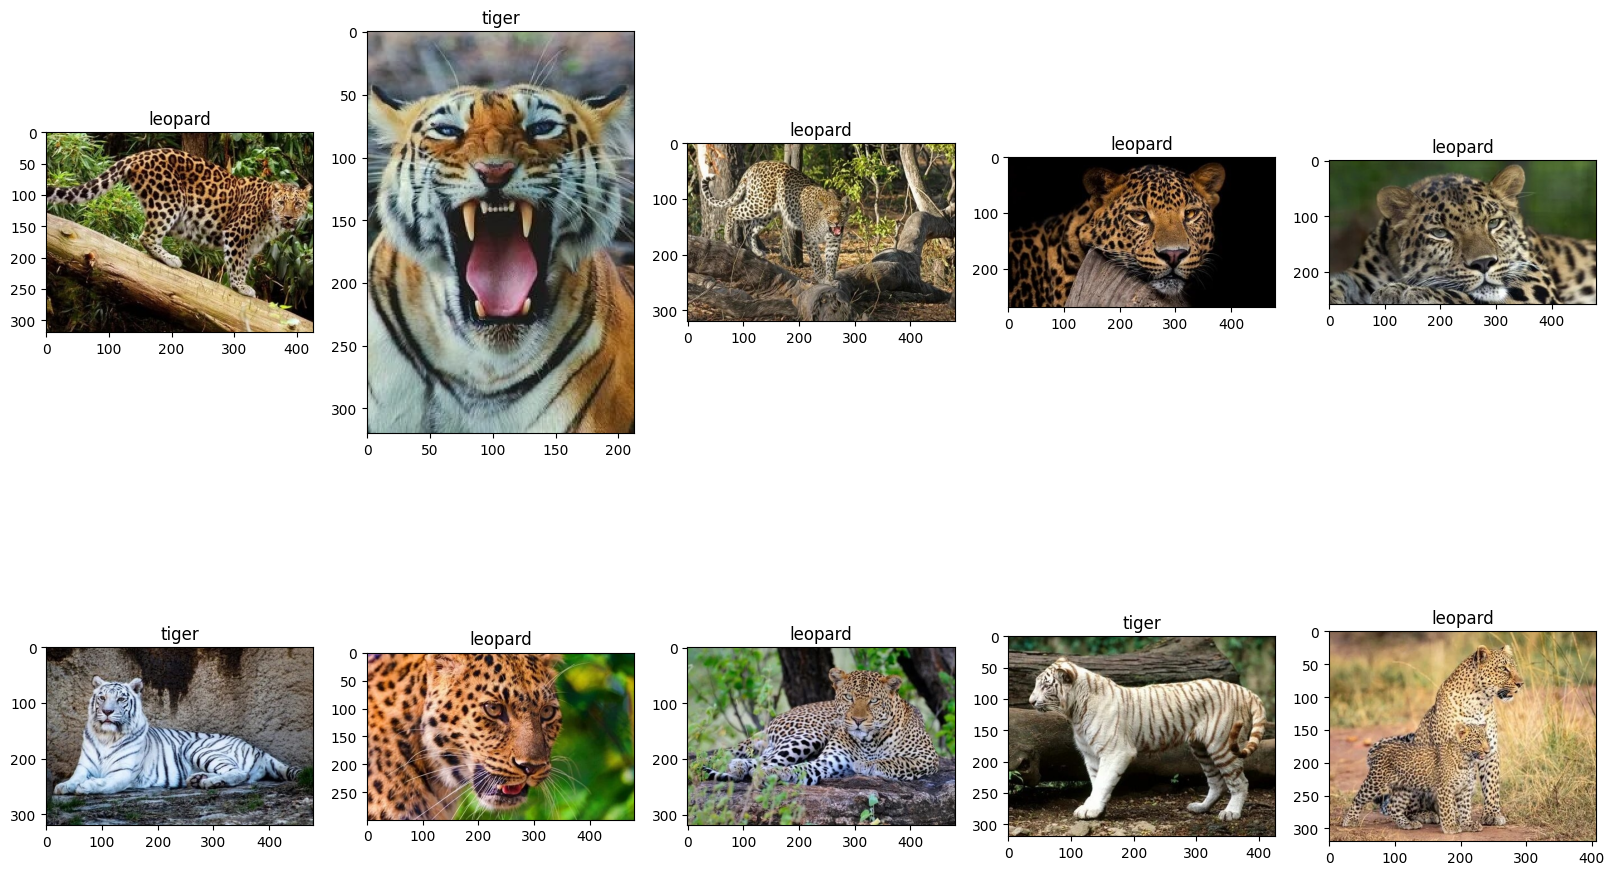

In [25]:
#Evaluate the quality of the model on a test sample
class_ = {0: 'leopard', 1: 'tiger'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():

    i = random.choice(submission['id'].values)

    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0

    img_path = os.path.join(test_path, f'{i}.jpg')
    img = Image.open(img_path)

    ax.set_title(class_[label])
    ax.imshow(img)

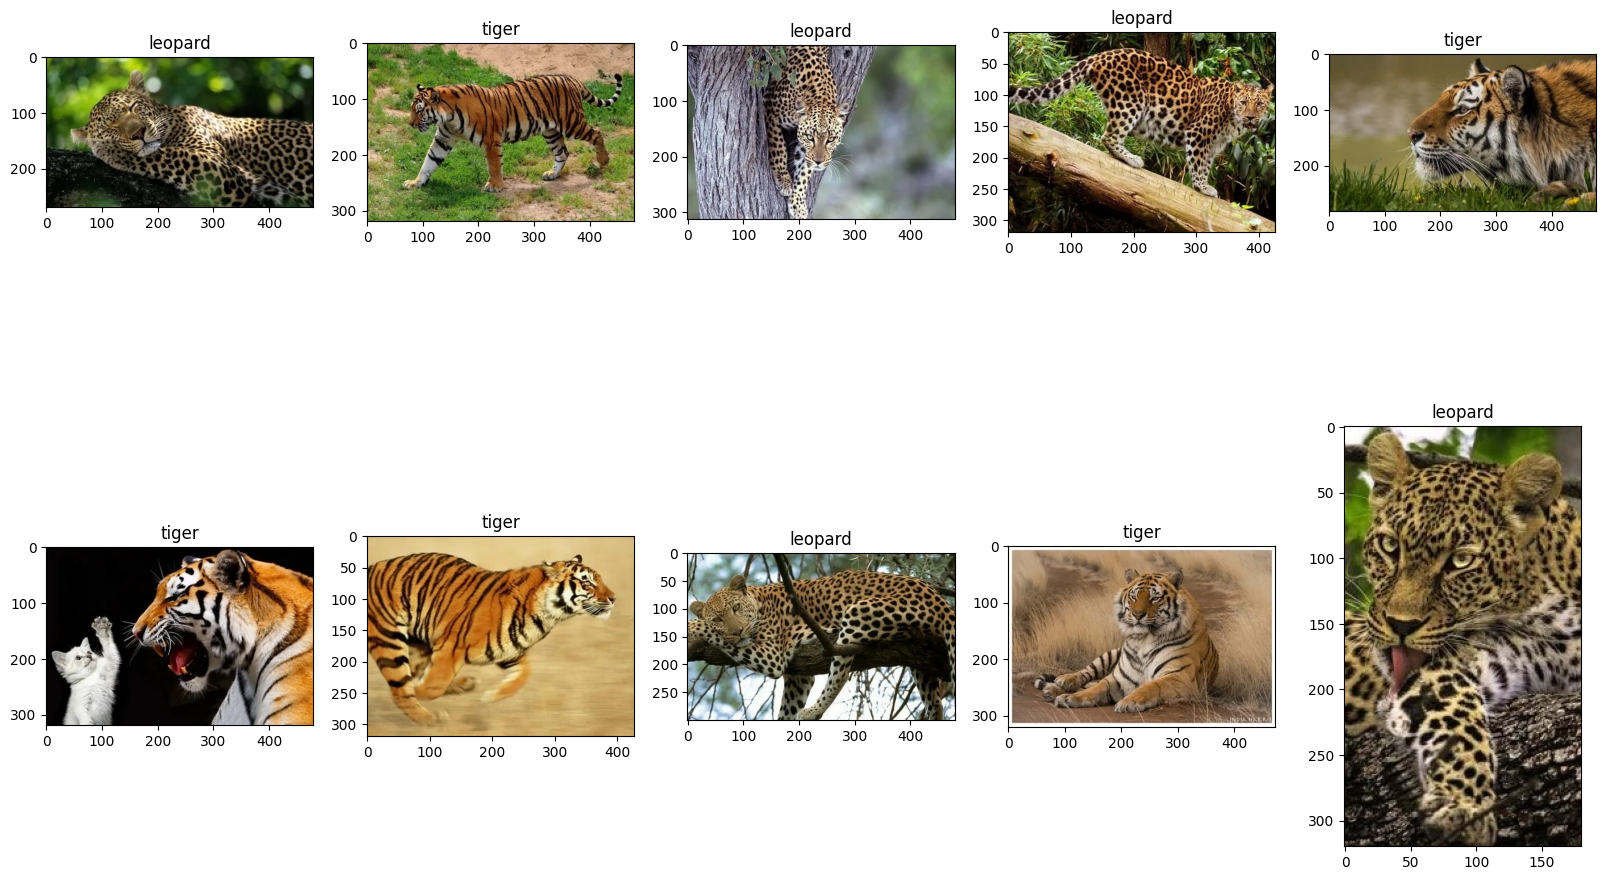

In [26]:
#Save the trained model
torch.save(model.state_dict(), 'ConvNetModel.pth')

loaded_model = ConvNet().to(device)
loaded_model.load_state_dict(torch.load('ConvNetModel.pth'))
loaded_model.eval()

leopard_probs = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        preds = loaded_model(images)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        leopard_probs += list(zip(labels, preds_list))

idx = list(map(lambda x: x[0],leopard_probs))
prob = list(map(lambda x: x[1],leopard_probs))

submission = pd.DataFrame({'id':idx,'label':prob})

class_ = {0: 'leopard', 1: 'tiger'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():

    i = random.choice(submission['id'].values)

    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0

    img_path = os.path.join(test_path, f'{i}.jpg')
    img = Image.open(img_path)

    ax.set_title(class_[label])
    ax.imshow(img)